In [137]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import pickle
import time

from seaborn import plt
%matplotlib inline

In [15]:

def get_page(link):
    result = requests.get(link)
    assert (result.status_code == 200),"Can't fetch main draft page"
    page = result.text
    return page

def get_info(row):
    college = row.find('td', {'data-stat': 'college_name'})
    player = row.find('td', {'data-stat': 'player'})
    if player and player.a:
        link = player.a['href']
        draft_rank = row.find('td', {'data-stat': 'pick_overall'}).text
        seasons = row.find('td', {'data-stat': 'seasons'}).text
        name = player.text
        return [link, draft_rank, seasons, name]


In [40]:
df = pd.DataFrame(columns = ['link', 'name', 'per', 'draft_rank', 'draft_year'])

In [41]:

draft_link = 'http://www.basketball-reference.com/draft/NBA_{}.html'

In [42]:
for i in range(1970, 2013):
    page = get_page(draft_link.format(i))
    soup = BeautifulSoup(page, 'html.parser')
    body = soup.find(id='stats').tbody
    for row in body.find_all('tr'):
        info = get_info(row)
        if info:
            link, draft_rank, seasons, name = info
            df = df.append({'name': name,
                            'link': link,
                            'draft_rank': draft_rank,
                            'seasons': seasons,
                            'draft_year': i
                           }, ignore_index=True, verify_integrity=True)
    cur = i
    time.sleep(0.1)


In [72]:
df_per = pd.read_csv('data/data_salary.csv')

In [73]:
df_per = df_per[['name', 'per']]

In [74]:
df_per = df_per.drop_duplicates('name')

In [75]:
df_per.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 0 to 1690
Data columns (total 2 columns):
name    1646 non-null object
per     1641 non-null float64
dtypes: float64(1), object(1)
memory usage: 38.6+ KB


In [76]:
df_per = df_per.dropna()

In [77]:
df = pd.read_csv('data/data_from_1970.csv', index_col=0)


In [78]:
df = df.drop('per', axis=1) 

In [79]:
df = df.merge(df_per, on='name', how='outer')

In [81]:
df = df.drop_duplicates('link')

In [82]:
dup_links = list(df[df.name.duplicated()]['link'])

In [85]:
dup_links.extend(list(df[df.per.isnull()]['link']))

In [93]:
def fetch_per(soup):
    per = soup.find('h4', text='PER').find_next_sibling().text
    return float(per)

In [91]:
soup = BeautifulSoup(get_page('http://www.basketball-reference.com' + dup_links[0]), 'html.parser')

In [94]:
fetch_per(soup)

12.4

In [97]:
for link in dup_links:
    soup = BeautifulSoup(get_page('http://www.basketball-reference.com' + dup_links[0]), 'html.parser')
    per = fetch_per(soup)
    df.loc[df.link==link, 'per'] = per

In [96]:
df.loc[df.link==dup_links[0]]

,link,name,draft_rank,draft_year,seasons,per
9,/players/j/johnsge02.html,George Johnson,79.0,1970.0,13.0,12.4


In [100]:
df.to_csv('data/data_from_1970.csv')

In [101]:
df_super = df[df.per > 20 ]

In [102]:
df_super.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 707 to 2378
Data columns (total 6 columns):
link          40 non-null object
name          40 non-null object
draft_rank    40 non-null float64
draft_year    40 non-null float64
seasons       40 non-null float64
per           40 non-null float64
dtypes: float64(4), object(2)
memory usage: 2.2+ KB


In [109]:
df_time_series = df_super.groupby('draft_year', as_index=False)['name'].count()

In [113]:
years = list(df_time_series.draft_year.unique())

In [119]:
for i in range(1980, 2012):
    if i not in years:
        df_time_series = df_time_series.append({'draft_year':i, 'name': 0}, ignore_index=True)

In [121]:
df_time_series = df_time_series.sort_values('draft_year')

In [124]:
df_time_series.columns = ['draft_year', 'count']

In [126]:
df_time_series['prev_count'] = df_time_series['count'].shift()

In [128]:
df_time_series['prev_2_count'] = df_time_series['count'].shift(2)

In [129]:
df_time_series['prev_3_count'] = df_time_series['count'].shift(3)

In [133]:
df_time_series = df_time_series.reset_index()

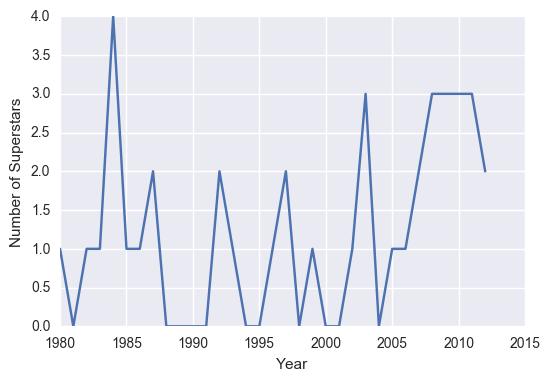

In [142]:
plt.plot( range(1980, 2013), df_time_series['count'])
plt.xlabel('Year')
plt.ylabel('Number of Superstars')
